In [1]:
import imageio as iio
import numpy as np
from matplotlib import pyplot as plt

In [2]:
fileName = "./Images/test_simp.png"

img = iio.imread(fileName)
imgNP = np.asarray(img)

imgH, imgW, imgCh= imgNP.shape
print("Image Size is {} and Acutal Memory required is  {} kilo Bytes".format(imgNP.shape, imgW*imgH*imgCh/1024.0))

Image Size is (100, 190, 3) and Acutal Memory required is  55.6640625 kilo Bytes


In [3]:
def get_qoi_desc(W, H, CH):
    MAGIC_32 = [ord('q'), ord('o'), ord('i'), ord('f')]

    WIDTH_32 = [(W>>24) & 0xFF, (W>>16) & 0xFF, (W>>8) & 0xFF, (W>>0) & 0xFF]
    HEIGHT_32 = [(H>>24) & 0xFF, (H>>16) & 0xFF, (H>>8) & 0xFF, (H>>0) & 0xFF]
    CHANNEL_8 = [CH & 0xFF]
    COLORSPACE_8 = [0 & 0xFF]
    # print(bytes(MAGIC_32), bytes(WIDTH_32), bytes(HEIGHT_32),bytes(CHANNEL_8), bytes(COLORSPACE_8))
    return bytes(MAGIC_32) + bytes(WIDTH_32) + bytes(HEIGHT_32) + bytes(CHANNEL_8) + bytes(COLORSPACE_8)

def get_qoi_rgbformat(pixel):
    QOI_OP_RGB = [0b11111110, pixel[0], pixel[1], pixel[2]]
    return bytes(QOI_OP_RGB)

def get_qoi_runformat(pixel, runVal):
    # run - 1 # Since run has a bias of 1, so, runVal =0 means run =1 , runVal =1 means run =2 and so on
    # it can go till only 62 as 63 and 64 are used for RGB format and RGBA format
    # so actual range of run is 1 to 62
    # range of runVAl is 0 to 61 
    # it can be seen that run = 63 and run =64 will lead to runVal = 62 and runVal = 63, hence we use 6 bits 
    # -- but we don't use RGB format and RGBA format for run    
    QOI_OP_RUN = [0b11000000 | ((runVal-1) & 0b00111111)]
    return bytes(QOI_OP_RUN)

def get_qoi_indexformat(pixel, index):
    QOI_OP_INDEX = [0b00000000 | (index & 0b00111111)]
    return bytes(QOI_OP_INDEX)



def get_qoi_smalldifformat(pixel, diff):
    QOI_OP_DIFF = [0b01000000 | ( ((diff[0] +2 ) <<4)  | ((diff[1] +2 ) <<2)   | ((diff[2] +2 ) <<0) )]
    return bytes(QOI_OP_DIFF)

def get_qoi_mediumdifformat(pixel, diff, dr_dg, db_dg):
    # print(diff)    
    QOI_OP_LUMA = [0b10000000 | ((diff[1] + 32) & 0b00111111),  (((dr_dg + 8 )<<4) & 0b11110000 ) | ((db_dg + 8 ) & 0b00001111) ]
    return bytes(QOI_OP_LUMA)

def get_qoi_hash(pixel):
    # (r * 3 + g * 5 + b * 7 + a * 11) % 64
    # (r * 3 + g * 5 + b * 7 + a * 11)  & 0b00111111
    gg = pixel.astype(np.int16)
    return ( (gg[0]*3) +  (gg[1]*5) +(gg[2]*7) + (255*11)) %64 # alpha is 255 if not availabel



def get_qoi_endmark():
    return bytes([0,0,0,0,0,0,0,1])

In [4]:
flattendedImag = imgNP.reshape(imgH * imgW, imgCh)

# INDEX_LIST = np.zeros((64,3), dtype=np.uint8)
INDEX_LIST = [None for i in range(64)]

prevPix = np.zeros((3,), dtype=np.uint8)


myBytest = get_qoi_desc(W=imgW, H= imgH, CH = imgCh)

run = 0

px_len =imgW* imgH
px_end = px_len


for i in range(flattendedImag.shape[0]):
    currPix = flattendedImag[i]

    hashIndex = get_qoi_hash(currPix)

    diff = currPix.astype(np.int16) - prevPix.astype(np.int16)
    # print(i, currPix, diff)
    dr_dg = diff[0] - diff[1]
    db_dg = diff[2] - diff[1]

    
    if np.array_equal(currPix, prevPix): # if previous pixel obtained is equl to current pixel, use run length encoding
        run = run + 1 # run gives the repedition count
        # NOTE: we are just couting the run, only when they become unequal we create a byte for it

        
        if run == 62 or i == px_end-1: # SHOULD HANDLE PX_POS = PX_END
            


            currentBytes = get_qoi_runformat(currPix, run)
            myBytest = myBytest + currentBytes

            run = 0
        
        # no need add if crun length edncoding
    else:
        # creation the byte for run length encoding only if prev and current are not euqal

        if run > 0:
            
          
            currentBytes = get_qoi_runformat(currPix, run)
            myBytest = myBytest + currentBytes

            run = 0
        

        # also we have to process the curr pix
        if np.array_equal(INDEX_LIST[hashIndex], currPix):  #checking if we have seen

            currentBytes = get_qoi_indexformat(currPix, hashIndex)
            myBytest = myBytest + currentBytes

            # noneed to add to INDEX LIST as alredy present

        elif -2 <= diff[0] <= 1 and  -2 <= diff[1] <= 1  and -2 <= diff[2] <= 1 :


            currentBytes = get_qoi_smalldifformat(currPix, diff)
            myBytest = myBytest + currentBytes

            INDEX_LIST[hashIndex] = currPix # since we have seen

        elif -8 <= dr_dg <= 7 and  -32 <= diff[1] <= 31  and -8 <= db_dg <= 7 :
            


            currentBytes = get_qoi_mediumdifformat(currPix, diff, dr_dg, db_dg)
            # print(list(currentBytes))
            myBytest = myBytest + currentBytes

            INDEX_LIST[hashIndex] = currPix # since we have seen
        else:

            currentBytes = get_qoi_rgbformat(currPix)
            myBytest = myBytest + currentBytes

            INDEX_LIST[hashIndex] = currPix # since we have seen


    prevPix = currPix
    # if i > 18995:
    #     print(i, currPix, prevPix, list(currentBytes))
    
myBytest = myBytest + get_qoi_endmark()

print(len(myBytest))
with open("outputImage.qoi","wb") as f:
    f.write(myBytest)
    f.close()
print("Compressed Memory required is  {} kilo Bytes".format(len(myBytest)/1024.0))

30758
Compressed Memory required is  30.037109375 kilo Bytes


In [5]:
with open("./MemFiles/encodedQOIImage.mem","w") as f:
    # st = ''
    for i in myBytest:
        st = hex(i)[2:] + '\n'
        f.write(st)
    f.close()

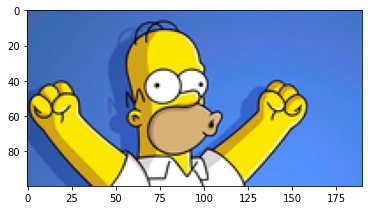

In [6]:
with open("./outputRGB.txt","r") as f:
    g =f.readlines()
    f.close()
gg = []
for i in g:
    m=i.strip(' ').strip('\n').split(',')
    m = [int(j) for j in m]
    gg.append(m)


for i in range(imgH*imgW):
    gaa = np.sum(flattendedImag[i,:] == gg[i])
    if gaa != 3:
        print(i,gaa , flattendedImag[i,:] , gg[i])

decodedImg = np.asarray(gg, dtype=np.uint8).reshape(imgH, imgW , 3)
plt.imshow(decodedImg)
plt.show()